In [1]:
import pandas as pd
pd.options.plotting.backend = "plotly"
pd.set_option('display.max_columns', None)


X_train = pd.read_csv('../data/train_values.csv', index_col='building_id')
y_train = pd.read_csv('../data/train_labels.csv', index_col='building_id')

X_test = pd.read_csv('../data/test_values.csv', index_col='building_id')

### Select features

In [2]:
X_train[['geo_level_1_id','geo_level_2_id','geo_level_3_id']] = X_train[['geo_level_1_id','geo_level_2_id','geo_level_3_id']].astype(str)
X_test[['geo_level_1_id','geo_level_2_id','geo_level_3_id']] = X_test[['geo_level_1_id','geo_level_2_id','geo_level_3_id']].astype(str)

X_train[['count_floors_pre_eq','age','area_percentage','height_percentage']] = X_train[['count_floors_pre_eq','age','area_percentage','height_percentage']].astype(float)

X_train['volume_percentage']=X_train['area_percentage'] * X_train['height_percentage']
X_test['volume_percentage']=X_test['area_percentage'] * X_test['height_percentage']

# Categorical columns 
categorical_columns = [c for c in X_train.select_dtypes(include=['object'])]
numerical_columns= list(set(X_train.columns) - set(categorical_columns))

### Split data

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=0)

### Define Pipeline

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import TargetEncoder

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('target', TargetEncoder(target_type="continuous"))
])

# Bundle preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_columns),
        ("numerical", "passthrough", numerical_columns),
    ])


# the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


model = RandomForestClassifier(max_depth=None, n_estimators=300, random_state=57)

clf = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('classifier', model)])


#param_grid = {
#    'classifier__n_estimators': [200, 300, 400],
#    'classifier__max_depth': [None, 50, 100]
#}
#
#grid_search = GridSearchCV(clf, param_grid, 
#                           cv=2, n_jobs=1,
#                           scoring='f1_micro',verbose=3)

clf.fit(X_train, y_train['damage_grade'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('target',
                                                                   TargetEncoder(target_type='continuous'))]),
                                                  ['geo_level_1_id',
                                                   'geo_level_2_id',
                                                   'geo_level_3_id',
                                                   'land_surface_condition',
                                                   'foundation_type',
                                                   'roof_type',
                                                   'ground_floor_type',
                                                   'other_floor_type',
                                                   'position',
                                                   'plan_configuration',
                                                   'legal_ownership_status']),
                                                 ('num...
                                                   'has_secondary_use_health_post',
                                                   'has_secondary_use_use_police',
                                                   'has_superstructure_mud_mortar_brick',
                                                   'has_secondary_use_agriculture',
                                                   'has_secondary_use_rental',
                                                   'height_percentage',
                                                   'has_secondary_use_institution',
                                                   'has_superstructure_cement_mortar_stone',
                                                   'has_superstructure_bamboo'])])),
                ('classifier',
                 RandomForestClassifier(n_estimators=300, random_state=57))])

### F1 Score

In [6]:
from sklearn.metrics import f1_score

pred_valid = clf.predict(X_valid)
my_f1_score = f1_score(y_valid, pred_valid, average='micro')
print(f"F1 score: {my_f1_score}")


F1 score: 0.7428867443065177


### Confussion Matrix

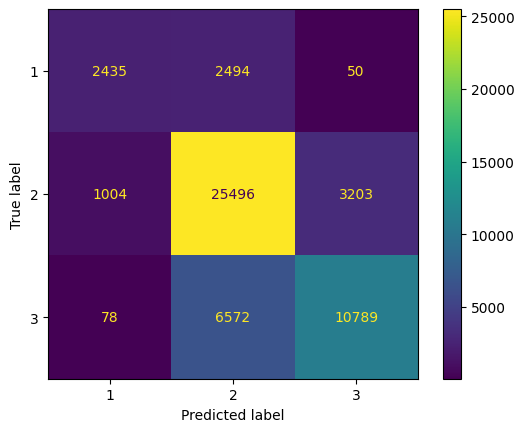

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_valid, y_valid)

### Create submission file

In [8]:
pred_test = clf.predict(X_test)

my_submission = pd.DataFrame(data=pred_test,
                             columns=['damage_grade'],
                             index=X_test.index)

my_submission.to_csv('pred_test_random_forrest.csv')